<a href="https://colab.research.google.com/github/KennyZhang-17/Dicom-File-Processing-Toronto-Western/blob/master/Process_of_Dicom_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# code revised from https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
%matplotlib inline
!pip install dicom
#!pip install dicom
import numpy as np
import dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

In [ ]:
data_path = "/content/t2"
output_path = working_path = "/home/Documents/"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 76 DICOM images.
First 5 filenames:
/content/t2/IMG0000000062.dcm
/content/t2/IMG0000000051.dcm
/content/t2/IMG0000000066.dcm
/content/t2/IMG0000000071.dcm
/content/t2/IMG0000000073.dcm


In [ ]:
#      
# Loop over the image files and store everything into a list.
# 
#def load_scan(path):
#    ds = dicom.read_file(path + '/' + s) for s in os.listdir(path) if os.path.isfile(s))
#    pixel_data = list()
#    for record in ds.DirectoryRecordSequence:
#        if record.DirectoryRecordType == "IMAGE":
        # Extract the relative path to the DICOM file
#            path = os.path.join(*record.ReferencedFileID)
#            dcm = dicom.read_file(path)
            # Now get your image data
#            pixel_data.append(dcm.pixel_array)
#    return pixel_data

#      
# Loop over the image files and store everything into a list.
# 
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path) if os.path.isfile(s)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
#    print(slices)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([scans[i].pixel_array for i in range(0,len(scans)-1)])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    '''    
    # Convert to Hounsfield units (HU) for CT
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    '''   
    return (np.array(image, dtype=np.int16))

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
#print(len(patient))
#print(np.stack([patient[i].pixel_array for i in range(0,52)]) )
#print(patient[52])

In [ ]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

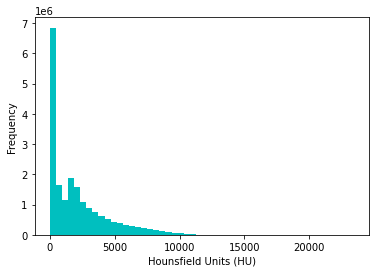

In [ ]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

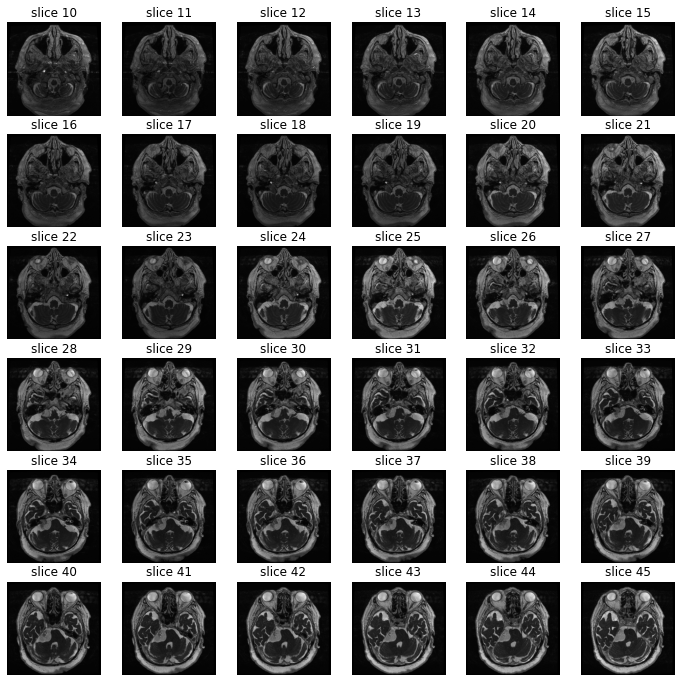

In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)


In [ ]:
print ("Slice Thickness: %f" % patient[0].SliceThickness)
print ("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 0.744300
Pixel Spacing (row, col): (0.390600, 0.390600) 


In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print ("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print ("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (75, 512, 512)
Shape after resampling	 (56, 200, 200)


In [ ]:
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_fc((0.7, 0.7, 0.7))
    plt.show()

Transposing surface
Calculating surface
Drawing


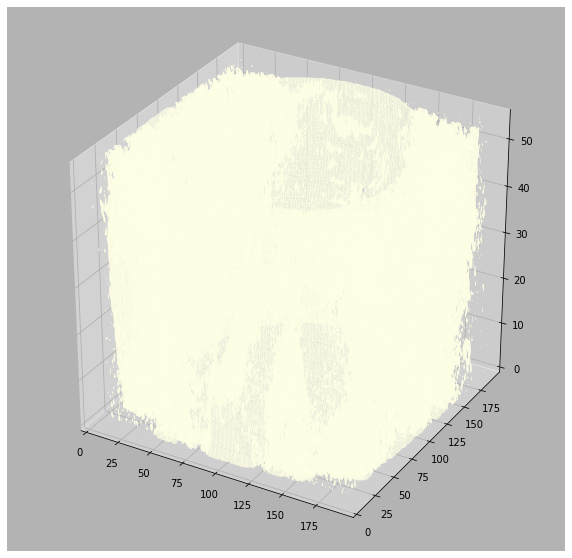

In [ ]:
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)